<a href="https://colab.research.google.com/github/NydiaLiu98/Transport_AI_Course/blob/main/Assignment_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Baseline

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [ ]:
url = 'https://raw.githubusercontent.com/zhenliangma/Applied-AI-in-Transportation/master/Exercise_7_Neural_networks/Exercise7BikeSharing.csv'
df = pd.read_csv(url)

# Feature engineering
target = 'cnt'
features = [
    'temp','atemp','hum','windspeed','weathersit',
    'hr','weekday','workingday','holiday','season','yr'
]

X = df[features].copy()
y = df[target].astype(float)

# Train / Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --------------------- neural network model architecture ---------------------------------
def build_neural_network_model(input_dim,
                 hidden_units=[64,64],
                 l2_reg=1e-4,
                 dropout=0.0,
                 lr=1e-3):
  model = Sequential()
  model.add(Input(shape=(input_dim,)))
  for units in hidden_units:
    model.add(Dense(units, activation='relu',kernel_regularizer=l2(l2_reg)))
    if dropout > 0.0:
     model.add(Dropout(dropout))
  model.add(Dense(1))

  optimizer = Adam(learning_rate=lr)

  model.compile(optimizer=optimizer,
         loss='mae',
         metrics=['mae'])

  return model

# -------------------------- train and eval -----------------------------------------------------------
def train_eval_model(X_train_scaled, y_train, X_test_scaled, y_test,
           hidden_units, l2_reg, dropout, lr, epochs=100, batch_size=32,
           plot=True,filepath = "weights.best.keras"):

  tf.keras.backend.clear_session()

  model = build_neural_network_model(input_dim=X_train_scaled.shape[1], hidden_units=hidden_units, l2_reg=l2_reg, dropout=dropout, lr=lr)

  # callbacks
  early_stop = EarlyStopping(monitor='val_mae', patience=5, restore_best_weights=True)
  reduce_lr = ReduceLROnPlateau(monitor='val_mae', factor=0.5, patience=3)
  checkpoint = ModelCheckpoint(filepath, monitor='val_mae', verbose=1, save_best_only=True, mode='min')

  hist = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=epochs, batch_size=batch_size, callbacks=[early_stop, reduce_lr,checkpoint],verbose=0)

  if plot:
    err = hist.history['mae']
    val_err = hist.history['val_mae']
    epochs = range(1, len(err) + 1)

    # Plot the Training MAE and Validation MAE over epochs.
    plt.plot(epochs, err, '-', label='Training MAE')
    plt.plot(epochs, val_err, ':', label='Validation MAE')
    plt.title('Training and Validation MAE')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.legend(loc='upper right')
    plt.plot()

  # Use the trained model to predict on the test data.
  y_pred = model.predict(X_test_scaled)

  # Calculate Mean Absolute Error (MAE), Mean Squared Error (MSE), and R-squared (R2) for the predictions.
  mae = mean_absolute_error(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)

  print("----- result of the trained model -----")
  print(f"Mean Absolute Error: {mae}")
  print(f"Mean Squared Error: {mse}")
  print(f"R-squared: {r2}")

  return {"mae":mae, "mse":mse, "r2":r2}, model

In [ ]:
param_list = [
    {"hidden_units": [64, 64], "dropout": 0.0, "l2_reg": 1e-4, "lr": 1e-3, "epochs": 200, "batch_size": 32},
    {"hidden_units": [64, 64], "dropout": 0.2, "l2_reg": 1e-4, "lr": 1e-3, "epochs": 200, "batch_size": 32},
    {"hidden_units": [64, 64], "dropout": 0.0, "l2_reg": 1e-4, "lr": 1e-2, "epochs": 200, "batch_size": 32},
    {"hidden_units": [64, 64], "dropout": 0.2, "l2_reg": 1e-4, "lr": 1e-2, "epochs": 200, "batch_size": 32},
    {"hidden_units": [128, 64], "dropout": 0.0, "l2_reg": 1e-4, "lr": 1e-3, "epochs": 200, "batch_size": 32},
    {"hidden_units": [128, 64], "dropout": 0.2, "l2_reg": 1e-4, "lr": 1e-3, "epochs": 200, "batch_size": 32},
    {"hidden_units": [128, 64], "dropout": 0.0, "l2_reg": 1e-4, "lr": 1e-2, "epochs": 200, "batch_size": 32},
    {"hidden_units": [128, 64], "dropout": 0.2, "l2_reg": 1e-4, "lr": 1e-2, "epochs": 200, "batch_size": 32},
    {"hidden_units": [128, 64, 32], "dropout": 0.0, "l2_reg": 1e-4, "lr": 1e-3, "epochs": 200, "batch_size": 32},
    {"hidden_units": [128, 64, 32], "dropout": 0.2, "l2_reg": 1e-4, "lr": 1e-3, "epochs": 200, "batch_size": 32},
    {"hidden_units": [128, 64, 32], "dropout": 0.0, "l2_reg": 1e-4, "lr": 1e-2, "epochs": 200, "batch_size": 32},
    {"hidden_units": [128, 64, 32], "dropout": 0.2, "l2_reg": 1e-4, "lr": 1e-2, "epochs": 200, "batch_size": 32},
]

all_results = []

for i, cfg in enumerate(param_list, 1):
    print(f"\n=== Running config {i}: {cfg} ===")
    metrics, model = train_eval_model(
        X_train_scaled, y_train, X_test_scaled, y_test,
        hidden_units=cfg["hidden_units"],
        dropout=cfg["dropout"],
        l2_reg=cfg["l2_reg"],
        lr=cfg["lr"],
        epochs=cfg["epochs"],
        batch_size=cfg["batch_size"],
        plot=False,
        filepath=f"model_{i}.keras"
    )

    result = {**cfg, **metrics}
    all_results.append(result)

df_results = pd.DataFrame(all_results)

print("\n=== All results ===")
print(df_results.sort_values('mae'))

best_cfg = df_results.loc[df_results['mae'].idxmin()].to_dict()
best_cfg = {k:v for k,v in best_cfg.items() if k in ["hidden_units", "dropout", "l2_reg","lr","epochs","batch_size"]}
print("\n=== Best config ===")
print(best_cfg)


=== Running config 1: {'hidden_units': [64, 64], 'dropout': 0.0, 'l2_reg': 0.0001, 'lr': 0.001, 'epochs': 200, 'batch_size': 32} ===

Epoch 1: val_mae improved from inf to 100.00564, saving model to model_1.keras

Epoch 2: val_mae improved from 100.00564 to 97.72240, saving model to model_1.keras

Epoch 3: val_mae improved from 97.72240 to 96.32481, saving model to model_1.keras

Epoch 4: val_mae improved from 96.32481 to 94.42238, saving model to model_1.keras

Epoch 5: val_mae improved from 94.42238 to 91.75573, saving model to model_1.keras

Epoch 6: val_mae improved from 91.75573 to 89.63882, saving model to model_1.keras

Epoch 7: val_mae improved from 89.63882 to 87.25650, saving model to model_1.keras

Epoch 8: val_mae improved from 87.25650 to 84.96027, saving model to model_1.keras

Epoch 9: val_mae improved from 84.96027 to 82.11732, saving model to model_1.keras

Epoch 10: val_mae improved from 82.11732 to 79.59306, saving model to model_1.keras

Epoch 11: val_mae improved 


Epoch 1: val_mae improved from inf to 77.84823, saving model to weights.best.keras

Epoch 2: val_mae improved from 77.84823 to 63.15564, saving model to weights.best.keras

Epoch 3: val_mae improved from 63.15564 to 52.50546, saving model to weights.best.keras

Epoch 4: val_mae improved from 52.50546 to 47.00457, saving model to weights.best.keras

Epoch 5: val_mae improved from 47.00457 to 46.11085, saving model to weights.best.keras

Epoch 6: val_mae improved from 46.11085 to 40.34713, saving model to weights.best.keras

Epoch 7: val_mae improved from 40.34713 to 38.17833, saving model to weights.best.keras

Epoch 8: val_mae did not improve from 38.17833

Epoch 9: val_mae improved from 38.17833 to 34.30069, saving model to weights.best.keras

Epoch 10: val_mae improved from 34.30069 to 34.04627, saving model to weights.best.keras

Epoch 11: val_mae did not improve from 34.04627

Epoch 12: val_mae did not improve from 34.04627

Epoch 13: val_mae did not improve from 34.04627

Epoch 1

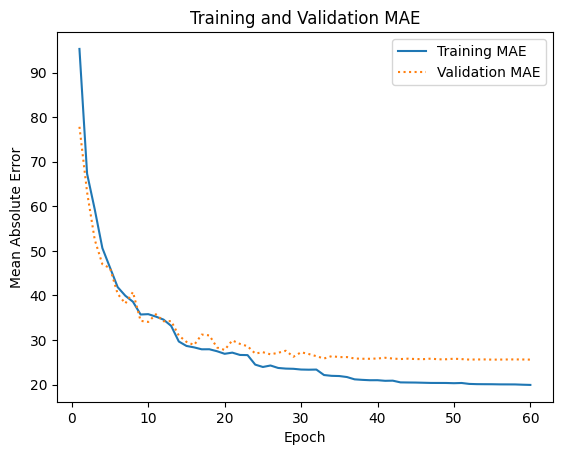

In [ ]:
best_metrics, best_model = train_eval_model(
        X_train_scaled, y_train, X_test_scaled, y_test,
        hidden_units=best_cfg["hidden_units"],
        dropout=best_cfg["dropout"],
        l2_reg=best_cfg["l2_reg"],
        lr=best_cfg["lr"],
        epochs=best_cfg["epochs"],
        batch_size=best_cfg["batch_size"],
        plot=True,
        filepath="weights.best.keras"
    )

# Adding interaction features

In [ ]:
df_new = df.copy()

df_new['hr_x_workingday'] = df_new['hr'] * df_new['workingday']
df_new['weathersit_x_hum'] = df_new['weathersit'] * df_new['hum']

features_new = ['temp','atemp','hum','windspeed','weathersit',
    'hr','weekday','workingday','holiday','season','yr',"hr_x_workingday","weathersit_x_hum"]

X_new = df_new[features_new].copy()
y_new = df_new['cnt'].astype(float)

X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_new_scaled = scaler.fit_transform(X_train_new)
X_test_new_scaled = scaler.transform(X_test_new)


Epoch 1: val_mae improved from inf to 76.80868, saving model to weights.best.interactions.keras

Epoch 2: val_mae improved from 76.80868 to 60.97659, saving model to weights.best.interactions.keras

Epoch 3: val_mae improved from 60.97659 to 49.16500, saving model to weights.best.interactions.keras

Epoch 4: val_mae improved from 49.16500 to 45.94826, saving model to weights.best.interactions.keras

Epoch 5: val_mae improved from 45.94826 to 39.64293, saving model to weights.best.interactions.keras

Epoch 6: val_mae did not improve from 39.64293

Epoch 7: val_mae did not improve from 39.64293

Epoch 8: val_mae improved from 39.64293 to 36.86415, saving model to weights.best.interactions.keras

Epoch 9: val_mae improved from 36.86415 to 36.75269, saving model to weights.best.interactions.keras

Epoch 10: val_mae improved from 36.75269 to 34.14901, saving model to weights.best.interactions.keras

Epoch 11: val_mae improved from 34.14901 to 33.23636, saving model to weights.best.interact

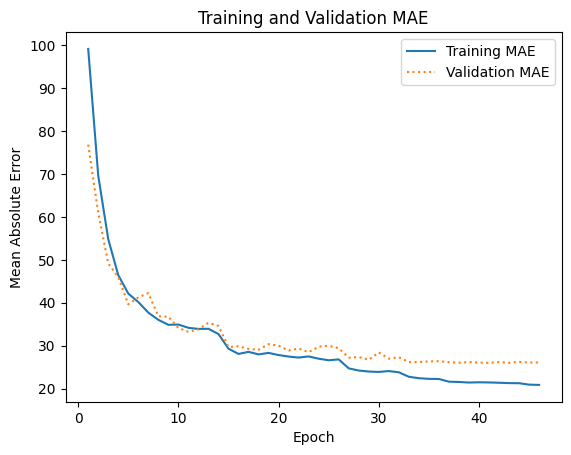

In [ ]:
metrics_new, model_new = train_eval_model(
        X_train_new_scaled, y_train_new, X_test_new_scaled, y_test_new,
        hidden_units=best_cfg["hidden_units"],
        dropout=best_cfg["dropout"],
        l2_reg=best_cfg["l2_reg"],
        lr=best_cfg["lr"],
        epochs=best_cfg["epochs"],
        batch_size=best_cfg["batch_size"],
        plot=True,
        filepath="weights.best.interactions.keras"
    )

print("Baseline:", best_metrics)
print("With interactions:", metrics_new)